## NOTEBOOK PARA AS PREVISOES DO PROJETO 4.

In [7]:
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import warnings
import locale
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')
warnings.filterwarnings('ignore')

#lendo os arquivos originais para poder separar os dados para uso
df_pjt_1 = pd.read_csv('../src/datasets/amostra_projeto1.csv', header=None)
df_pjt_2 = pd.read_csv('../src/datasets/amostra_projeto_2.csv', header=None)
df_pjt_3 = pd.read_csv('../src/datasets/amostra_projeto_3.csv', header=None)
df_pjt_4 = pd.read_csv('../src/datasets/projeto_4.csv', header=None)
projetos_xlsx = pd.read_excel('../src/datasets/amostras_projetos.xlsx', header=None)

#preparando dataframe para trabalhar os dados
dataframes = [df_pjt_1, df_pjt_2, df_pjt_3,df_pjt_4]
amostras = []
sufixos_saida = ['_1', '_2', '_3', '_4']
#Loop para a retirada das colunas e linhas indesejadas
for df_pjt in dataframes:
    amostra = df_pjt.iloc[0:9].copy()
    amostra = amostra.drop(amostra.columns[2:], axis=1)
    #transpoe o DataFrame
    amostra = amostra.transpose()
    #usa a primeira linha como cabeçalho
    amostra.columns = amostra.iloc[0]
    #remove a primeira linha do DataFrame
    amostra = amostra[1:]
    #define a primeira coluna como indice e redefinE o indice
    amostra = amostra.set_index(amostra.columns[0]).reset_index(drop=True)
    amostras.append(amostra)
    
#desempacota as amostras para variaveis individuais
df_amostra_1, df_amostra_2, df_amostra_3, pjt_4 = amostras

#df_concatenado = pd.concat([df_amostra_1, df_amostra_2, df_amostra_3,pjt_4], ignore_index=True)

#salvando os dados separados para olhar depois
df_amostra_1.to_csv('../dados_amostras/dados_projeto_1.csv', index=False)
df_amostra_2.to_csv('../dados_amostras/dados_projeto_2.csv', index=False)
df_amostra_3.to_csv('../dados_amostras/dados_projeto_3.csv', index=False)
pjt_4.to_csv('../dados_amostras/dados_projeto_4.csv', index=False)

##SEGUNDA PARTE:

def limpar_converter_preco(valor):
    """
    Limpa e converte valores de preços como strings em um formato adequado para cálculos numéricos.

    Parâmetros:
    - valor (str): Valor de preço representado como string.

    Retorna:
    - float: Valor limpo e convertido para float, ou None se o valor não for válido.
    """
    #verifica se o valor é uma string não vazia
    if isinstance(valor, str) and valor.strip():
        #remove os caracteres nao numericoS, exceto a virgula
        valor_limpo = re.sub(r'[^\d,]', '', valor)  
        #faz a substituiçao da virgula decimal por um ponto
        valor_limpo = valor_limpo.replace(',', '.')
        #converte para float
        return float(valor_limpo)
    else:
        #retorna None se o valor estiver vazio ou nao for string
        return None  

#leitura das novas amostras trabalhadas no excel para a preparaçao das próximas etapas
df1 = pd.read_csv('../tabela_orçamento/nova_amostra_projeto_1.csv')
df2 = pd.read_csv('../tabela_orçamento/nova_amostra_projeto_2.csv')
df3 = pd.read_csv('../tabela_orçamento/nova_amostra_projeto_3.csv')

#vai transformar item em uma especie de 'ID' para eu conseguir trabalha-los melhor
dataframes = [df1, df2, df3]
novo_df = []
colunas_drop_index = [2] #o 2 é o indice da coluna "Unitário - Preço Material" vou derrubar ela logo abaixo
colunas_drop = ["Referência", "Tipo", "Código", "Unid.", "BDI","Quantidade", "Unitário - Preço Material", "Unitário - Preço Execução", "Unitário - Preço"]
colunas_rename = {"Total - Preço Material": "TOTAL_MATERIAL",
                  "Total - Preço Execução ": "PRECO_EXEC",
                  "Total - Preço Execução": "PRECO_EXEC",
                  "Total - Preço": "TOTAL_PRECO"}

df1['Titulo'] = 'Projeto 1'
df2['Titulo'] = 'Projeto 2'
df3['Titulo'] = 'Projeto 3'

#loop para aplicar a transformação em cada DataFrame
for x in dataframes:
    x.drop(columns=colunas_drop, inplace=True, errors='ignore')
    x.drop(columns=x.columns[colunas_drop_index], inplace=True, errors='ignore')
    x.rename(columns=colunas_rename, inplace=True)
    if 'TOTAL_PRECO' in x.columns:
        x['TOTAL_PRECO'] = x['TOTAL_PRECO'].apply(limpar_converter_preco)
    novo_df.append(x[x['Item'].astype(str).apply(lambda y: y.endswith('.') and y[:-1].isdigit())].iloc[0:])

df1, df2, df3 = novo_df

df1['TOTAL_PROJETO'] = df1['TOTAL_PRECO'].sum()
df2['TOTAL_PROJETO'] = df2['TOTAL_PRECO'].sum()
df3['TOTAL_PROJETO'] = df3['TOTAL_PRECO'].sum()

##TERCEIRA PARTE

#Mergeando esses carinhas para a previsão
df_merge_1 = pd.merge(df1, df_amostra_1,how='outer')
df_merge_2 = pd.merge(df2, df_amostra_2,how='outer')
df_merge_3 = pd.merge(df3, df_amostra_3,how='outer')

#shiftando os valores
colunas = ['Área Terreno', 'Área Construída']
df_merge_1[colunas] = df_merge_1[colunas].bfill()
df_merge_2[colunas] = df_merge_2[colunas].bfill()
df_merge_3[colunas] = df_merge_3[colunas].bfill()

df_merge_1[colunas] = df_merge_1[colunas].bfill()
df_merge_2[colunas] = df_merge_2[colunas].bfill()
df_merge_3[colunas] = df_merge_3[colunas].bfill()

#dropando algumas linhas
df_merge_1 = df_merge_1.drop(index=16, errors='ignore')
df_merge_2 = df_merge_2.drop(index=16, errors='ignore')
df_merge_3 = df_merge_3.drop(index=16, errors='ignore')

dataframes = [df_merge_1, df_merge_2, df_merge_3]

for df in dataframes:
    df['Área Terreno'] = df['Área Terreno'].apply(limpar_converter_preco)
    df['Área Construída'] = df['Área Construída'].apply(limpar_converter_preco)
    
#CONCATENANDO PARA PODER TREINAR O MODELO.
df_concatenado = pd.concat(dataframes)
df_concatenado = df_concatenado.drop(['Área Terreno',"Item", "TOTAL_MATERIAL","PRECO_EXEC","TOTAL_PRECO","Titulo","Descrição","Área Fundação", "Área Fachada", "Área Parede", "Qtde BWCs", 'Tipologia'],axis=1).reset_index(drop=True)

#aqui vou criar um novo DataFrame com 16 linhas e as colunas desejadas para adicionar ao modelo.
df_novo = pd.DataFrame({'TOTAL_PROJETO': [None]*16, 'Área Construída': [257.0]*16})

#AQUI COMEÇA O TREINAMENTO DO MODELO DE REGRESSAO LINEAR PARA O ORÇAMENTO DO PROJETO4
#precisei separar os dados em recursos (x) e rótulos (y)
X = df_concatenado[['Área Construída']]
y = df_concatenado['TOTAL_PROJETO']

#separando também conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#treinamento do modelo de regressão linear
modelo = LinearRegression()
modelo.fit(X_train, y_train)

#O score vai avaliar o modelo
score = modelo.score(X_test, y_test)
print("Score do modelo:", score)

#aqui acontece a previsão para o Projeto 4
area_construida_projeto4 = df_novo[['Área Construída']].iloc[0]
previsao_total_projeto4 = modelo.predict([area_construida_projeto4])
print("Previsão do valor total para o Projeto 4:", previsao_total_projeto4)

#Após a projeção e o score, criei um Dataframe para receber as informações do projeto4
#puxei o valor total para o Projeto 4
previsao_total_projeto4 = modelo.predict(df_novo[['Área Construída']])

#aqui atualiza a Coluna 'TOTAL_PROJETO' com as Previsões e também retorna ao valor monetário inicial
df_novo['TOTAL_PROJETO'] = previsao_total_projeto4
df_novo_cifra = df_novo.drop_duplicates()
df_novo_cifra['TOTAL_PROJETO'] = pd.to_numeric(df_novo['TOTAL_PROJETO'], errors='coerce')
df_novo_cifra['TOTAL_PROJETO'] = df_novo['TOTAL_PROJETO'].map(lambda x: locale.currency(abs(x), grouping=True))

#vou concatenar para adicionar o projeto 4 no dataframe junto dos outros para realizar uma visualizaçao
df_concatenado_cifra = df_concatenado.drop_duplicates()
df_concatenado_cifra['TOTAL_PROJETO'] = pd.to_numeric(df_concatenado['TOTAL_PROJETO'], errors='coerce')
df_concatenado_cifra['TOTAL_PROJETO'] = df_concatenado['TOTAL_PROJETO'].map(lambda x: locale.currency(abs(x), grouping=True))

#atente-se que troquei as variaveis para "cifra" no final, para termos o valor como valor monetário. O valor inteiro está na variavel que nao contem cifra em seu nome.
#esse dataframe é só para possuir uma opção no qual vemos todos os valores, mas é valido observar direto pelo "df_novo".
df_todos = pd.concat([df_concatenado_cifra, df_novo_cifra], ignore_index=True)
df_novo_cifra

Score do modelo: 0.9030595351708561
Previsão do valor total para o Projeto 4: [995639.58892733]


,TOTAL_PROJETO,Área Construída
0,"R$ 995.639,59",257.0


#### A Previsão do modelo foi de R$ 995.639,59 para o valor do projeto 4

In [8]:
df_novo_cifra

,TOTAL_PROJETO,Área Construída
0,"R$ 995.639,59",257.0


In [9]:
df_todos

,TOTAL_PROJETO,Área Construída
0,"R$ 1.051.728,17",246.63
1,"R$ 856.967,32",249.24
2,"R$ 1.523.008,39",425.00
3,"R$ 995.639,59",257.00


## VISUALIZAÇÃO RÁPIDA DE CORRELAÇÃO 

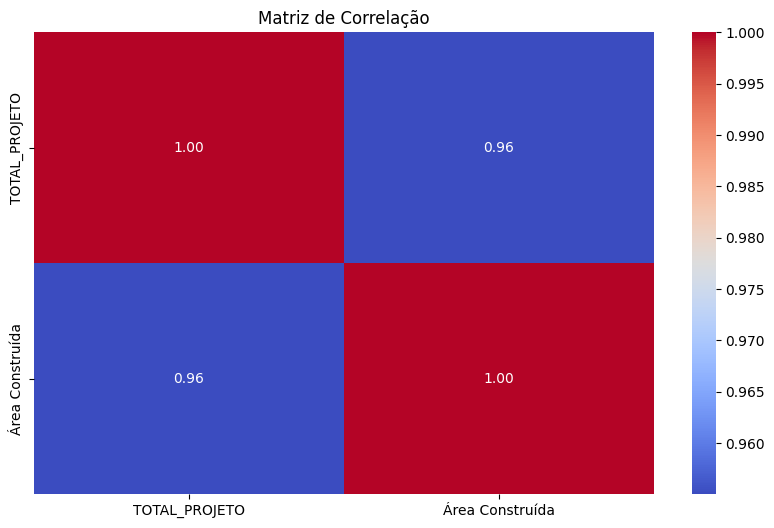

In [3]:
import seaborn as sns

# Calcular a matriz de correlação
correlation_matrix = df_concatenado.corr()

# Plotar a matriz de correlação
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação')
plt.show()
